In [1]:
import os
os.chdir("..")

In [2]:
import time
import pandas as pd
from lightning_lite.utilities.seed import seed_everything
from shell_data.dataset.dataset import get_train_val_test_subsets
import torch
import os
from shell_data.utils.config import (
    ShELLDataSharingConfig,
    DatasetConfig,
    TaskModelConfig,
    TrainingConfig,
    ExperienceReplayConfig,
    DataValuationConfig,
    RouterConfig,
    BoltzmanExplorationConfig,
)
from shell_data.utils.record import *
import numpy as np
from shell_data.shell_agent.shell_agent_classification import ShELLClassificationAgent
from itertools import combinations
import umap
from copy import deepcopy
from functools import partial


from shell_data.utils.utils import train
import matplotlib.pyplot as plt
# import mplcyberpunk
# plt.style.use("cyberpunk")
# plt.style.use('bmh')
import seaborn as sns
plt.style.use("fivethirtyeight")
# plt.style.use("xkcd")
sns.set_style("whitegrid")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import random
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"


os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
torch.use_deterministic_algorithms(True)

SEED = 0
seed_everything(SEED)

2023-02-06 18:13:55.208122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 18:13:55.769815: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-06 18:13:55.769862: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-06 18:13:55.769866: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

0

In [3]:
from shell_data.task_model.task_model import TaskModel, SupervisedLearningTaskModel
import torch.nn as nn

In [4]:
num_cls_per_task = 5
n_agents = 2
num_task_per_life = 2
buffer_integration_size = 50000  # sample all!
batch_size = 32
size = 64
routing_method = "random"

dataset_name = "mnist"

In [5]:
train_subsets, val_subsets, test_subsets = get_train_val_test_subsets(
        dataset_name)

In [6]:
cfg = ShELLDataSharingConfig(
        n_agents=n_agents,
        dataset=DatasetConfig(
            name=dataset_name,
            train_size=size,
            test_size=1.0,
            val_size=size//2,
            num_task_per_life=num_task_per_life,
            num_cls_per_task=num_cls_per_task,
        ),
        task_model=TaskModelConfig(
            name=dataset_name,
        ),
        training=TrainingConfig(
            n_epochs=50,
            batch_size=batch_size,
            patience=1000,
            val_every_n_epoch=1,
        ),
        experience_replay=ExperienceReplayConfig(
            buffer_size=buffer_integration_size,
        ),
          router=RouterConfig(
            strategy=routing_method,  # control how the sender decides which data point to send
            num_batches=1,
            estimator_task_model=TaskModelConfig(
                name=dataset_name,
            ),
            n_heads=n_agents,
          ),
    )

In [7]:
receiver = ShELLClassificationAgent(
        train_subsets, val_subsets, test_subsets, cfg)

train_size: 64, num_cls_per_task: 5


In [8]:
sender_cfg = deepcopy(cfg)
# sender_cfg.dataset.train_size = 1.0 # all of the data for testing purposes...
sender = ShELLClassificationAgent(
        train_subsets, val_subsets, test_subsets, sender_cfg)

train_size: 64, num_cls_per_task: 5


In [9]:
receiver.ll_dataset.perm = torch.tensor([0, 1, 3, 4, 9,     2, 5, 6, 7, 8])
sender.ll_dataset.perm = torch.tensor([0, 4, 9, 2, 5,       1, 3, 6, 7, 8])

# intersection be 0, 4, 9 (and 2 out of distribution!)

receiver.init_model_router()
sender.init_model_router()

In [10]:
if os.path.exists("./results/ood.pt"):
    print("Going to load...")
    receiver.load_model("./results/ood.pt")
    receiver.load_buffer("./results/ood_buffer_0")
else:
    print("Going to train...")
    receiver.learn_task(0, metric="val_acc", record_name="./results/ood.csv")
    receiver.save_model("./results/ood.pt")
    receiver.save_buffer("./results/ood_buffer_0")

Going to load...


In [11]:
snapshot_conf_mat(receiver, ll_time=0, record_name="./results/ood")

In [12]:
train, test, val = load_snapshot_conf_mats("./results/ood", ll_time=0)

In [13]:
df1, _, _ = summarize_confs([train, test, val], ["train", "test", "val"])
df1

/home/vlongle/code/shell-refactor-data/shell-data/shell_data/utils/record.py:65: RuntimeWarning: invalid value encountered in divide
  return np.diag(conf_mat) / conf_mat.sum(axis=1)


,name,acc,per_class_acc_0,per_class_acc_1,per_class_acc_2,per_class_acc_3,per_class_acc_4,per_class_acc_5,per_class_acc_6,per_class_acc_7,per_class_acc_8,per_class_acc_9
0,train,0.956250,0.984375,0.968750,NaN,0.968750,0.953125,NaN,NaN,NaN,NaN,0.906250
1,test,0.936278,0.970408,0.955947,NaN,0.936634,0.942974,NaN,NaN,NaN,NaN,0.874133
2,val,0.931250,1.000000,0.906250,NaN,0.875000,0.968750,NaN,NaN,NaN,NaN,0.906250


In [14]:
receiver_data = receiver.ll_dataset.get_train_dataset(0, kind="all")
sender_data = sender.ll_dataset.get_train_dataset(0, kind="all")

In [15]:
X_receiver = torch.stack([x for x, _ in receiver_data])
X_sender = torch.stack([x for x, _ in sender_data])

y_sender = torch.tensor([y for _, y in sender_data])
y_receiver = torch.tensor([y for _, y in receiver_data])

In [16]:
torch.unique(y_sender, return_counts=True), torch.unique(y_receiver, return_counts=True)

((tensor([0, 2, 4, 5, 9]), tensor([64, 64, 64, 64, 64])),
 (tensor([0, 1, 3, 4, 9]), tensor([64, 64, 64, 64, 64])))

## OOD Detector

In [17]:
from pytorch_ood.detector import (
     ODIN,
     EnergyBased,
     KLMatching,
     Mahalanobis,
     MaxLogit,
     MaxSoftmax,
     ViM,
     MCD,
 )


Detectors that don't require "fit" on the dataset and just hail Mary.

- MaxLogit: bad
- MaxSoftmax: ok. (tensor([0, 2, 4, 5, 9]), tensor([ 4, 20,  8, 22, 10]))
- MCD: ok. (tensor([0, 2, 4, 5, 9]), tensor([ 4, 20,  8, 22, 10]))

Detectors that require "fit" but only need IN samples (ignore OOD samples).
- KLMatching: (tensor([0, 2, 4, 5, 9]), tensor([ 6, 31,  6, 32,  5]))



In [18]:
receiver.model.net.embedding

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [19]:
receiver.model.net.to("cpu")
# detector = Mahalanobis(receiver.model.net.to("cpu"))
detector = Mahalanobis(receiver.model.net.features)

In [20]:
# remap receiver_data so that y classes are 0, 1, 2, 3, 4
y_receiver_remap = torch.zeros_like(y_receiver)
for i, y in enumerate(torch.unique(y_receiver)):
    y_receiver_remap[y_receiver == y] = i

receiver_data_remapped = torch.utils.data.TensorDataset(X_receiver, y_receiver_remap)

In [21]:
receiver_dataloader = torch.utils.data.DataLoader(
    receiver_data_remapped,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)
detector.fit(receiver_dataloader, device="cpu")

x.shape:  torch.Size([32, 10])
x.shape:  torch.Size([32, 10])
x.shape:  torch.Size([32, 10])
x.shape:  torch.Size([32, 10])
x.shape:  torch.Size([32, 10])
x.shape:  torch.Size([32, 10])
x.shape:  torch.Size([32, 10])
x.shape:  torch.Size([32, 10])
x.shape:  torch.Size([32, 10])
x.shape:  torch.Size([32, 10])


In [22]:
# training
with torch.no_grad():
    train_scores = detector(X_receiver)

x.shape:  torch.Size([320, 10])
x.shape:  torch.Size([320, 10])


TODO: actually use some thresholding for outlier detection (higher outlier scores is better so 
the std stuff might not be the right way bc distribution isn't symmetric)

mean tensor(0.0148)
upper bound tensor(0.0253)


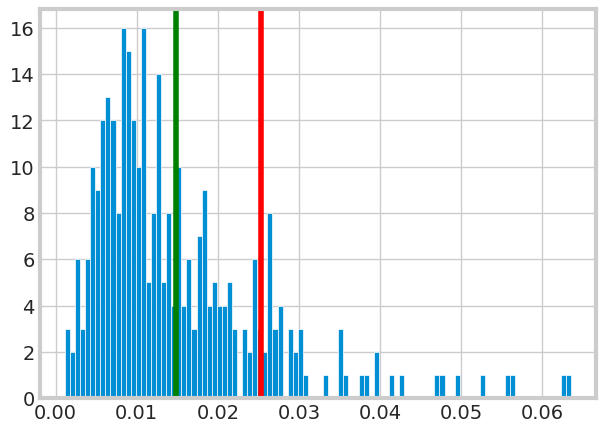

In [23]:
# plot the scores
# higher values indicate more likely to be OOD
m = torch.mean(train_scores.cpu())
print("mean", m)
plt.hist(train_scores.cpu().numpy(), bins=100);

k = 1
upper_bound = m + k * torch.std(train_scores.cpu())
print("upper bound", upper_bound)
plt.axvline(m, color="green", label="mean")
plt.axvline(upper_bound, color="red", label="upper bound");

In [24]:
# testing
with torch.no_grad():
    test_scores = detector(X_sender)

x.shape:  torch.Size([320, 10])
x.shape:  torch.Size([320, 10])


mean: tensor(0.0239)
upper bound: tensor(0.0253)


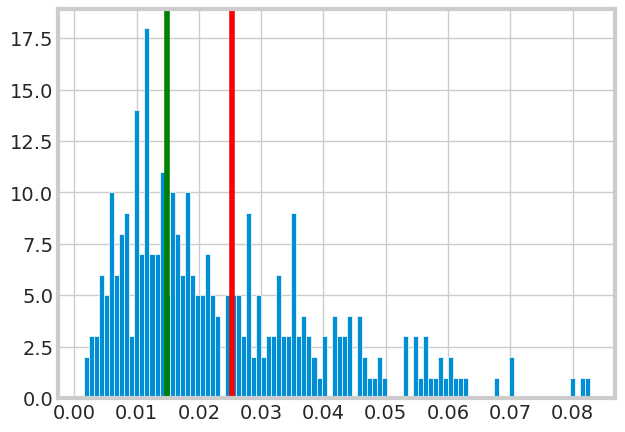

In [25]:
# plot the scores
# higher values indicate more likely to be OOD
print("mean:", torch.mean(test_scores.cpu()))
print("upper bound:", upper_bound)
plt.hist(test_scores.cpu().numpy(), bins=100);
plt.axvline(m, color="green", label="mean")
plt.axvline(upper_bound, color="red", label="upper bound");

In [26]:
outlier_idx = (test_scores > upper_bound).cpu()
print("Number of outliers:", outlier_idx.sum())
y_outlier = y_sender[outlier_idx]
print("Outlier labels:", torch.unique(y_outlier, return_counts=True))

Number of outliers: tensor(125)
Outlier labels: (tensor([0, 2, 4, 5, 9]), tensor([11, 50, 11, 46,  7]))


In [27]:
outlier_cls = [2, 5]
# compute the conf matrix, f1 score and shit
conf_mat = torch.zeros((len(outlier_cls), len(outlier_cls)))
for i, cls in enumerate(outlier_cls):
    for j, cls in enumerate(outlier_cls):
        conf_mat[i, j] = torch.sum((y_outlier == cls) * (y_sender == cls))

RuntimeError: The size of tensor a (125) must match the size of tensor b (320) at non-singleton dimension 0